In [48]:
#initialization
import pyspiel
import numpy as np
import matplotlib.pyplot as plt
import random
from open_spiel.python.egt import dynamics
from open_spiel.python.egt.utils import game_payoffs_array
from mpltern.datasets import get_triangular_grid


# Define games
biased_rock_paper_scissors = pyspiel.create_matrix_game("brps", "biased_rock_paper_scissors", ["R", "P", "S"], ["R", "P", "S"], [[0, -0.25, 0.5], [0.25, 0, -0.05], [-0.5, 0.05, 0]], [[0, 0.25, -0.5], [-0.25, 0, 0.05], [0.5, -0.05, 0]])
dispersion = pyspiel.create_matrix_game("d", "dispersion", ["A", "B"], ["A", "B"], [[-1, 1], [1, -1]], [[-1, 1], [1, -1]])
battle_of_the_sexes = pyspiel.create_matrix_game("bots", "battle_of_the_sexes", ["O", "M"], ["O", "M"], [[3, 0], [0, 2]], [[2, 0], [0, 3]])
prisoner_dilemma = pyspiel.create_matrix_game("pd", "prisoner_dilemma", ["C", "D"], ["C", "D"], [[-1, -4], [0, -3]], [[-1, 0], [-4, -3]])

# # ε-greedy
# # Define Action class
# class Actions:
#     def __init__(self, action, learningrate):
#         self.action = action
#         self.mean = 0
#         self.N = 0
#         self.last_rewards = []
#         self.learningrate = learningrate

#     # Update the action-value estimate
#     def update(self, x):
#         self.last_rewards += [x]
#         update_val = max(self.last_rewards)
#         #print("updateval ", update_val)
#         self.N += 1
#         #print("n ", self.N)
#         #self.mean = (1 - 1.0 / self.N) * self.mean + 1.0 / self.N * update_val
#         self.mean = (1 - self.learningrate) * self.mean + self.learningrate * update_val
#         #print("qval ", self.mean)
#         self.last_rewards = []



# # Perform ε-greedy
# def epsilon(game, eps1, eps2, itt, learningrate=0.01):
#     # Get actions
#     state = game.new_initial_state()
#     temp_actions_player_1 = state.legal_actions(0)
#     temp_actions_player_2 = state.legal_actions(1)
#     actions_player_1 = []
#     actions_player_2 = []

#     for action in temp_actions_player_1:
#         actions_player_1 += [Actions(action,learningrate)]
#     for action in temp_actions_player_2:
#         actions_player_2 += [Actions(action,learningrate)]
#     data1 = np.empty(itt)
#     data2 = np.empty(itt)
#     data3= np.empty(itt)
#     data4 = np.empty(itt)
#     start1 = True
#     start2 = True

#     policies_player1 = np.empty(itt)
#     policies_player2 = np.empty(itt)

#     for i in range(itt):
#         number1 = np.random.random()
#         number2 = np.random.random()
#         print
#         if number1 < eps1 or start1:
#             action1 = random.choice(actions_player_1)
#         else:
#             action1 = actions_player_1[np.argmax([act.mean for act in actions_player_1])]
#         if number2 < eps2 or start2:
#             action2 = random.choice(actions_player_2)
#         else:
#             action2 = actions_player_2[np.argmax([act.mean for act in actions_player_2])]
#         data3[i]=actions_player_1[0].N
#         data4[i]=actions_player_2[0].N
#         start1 = False
#         start2 = False

#         state = game.new_initial_state()
#         state.apply_actions([action1.action, action2.action])
#         results = state.returns()
#         action1.update(results[0])
#         action2.update(results[1])

#         # for the plot
#         data1[i] = results[0]
#         data2[i] = results[1]
        
#     cumulative_average1 = np.cumsum(data1) / (np.arange(itt) + 1)
#     cumulative_average2 = np.cumsum(data2) / (np.arange(itt) + 1)
#     cumulative_average3 = data3 / (np.arange(itt)+1)
#     cumulative_average4 = data4 / (np.arange(itt)+1)

    

#     return [cumulative_average3, cumulative_average4]





In [52]:
class Actions:
    def __init__(self, action, learning_rate):
        self.action = action
        self.mean = 0
        self.N = 0
        self.last_rewards = []
        self.learning_rate = learning_rate

    # Update the action-value estimate
    def update(self, x):
        self.last_rewards.append(x)
        self.N += 1
        self.mean = (1 - self.learning_rate) * self.mean + self.learning_rate * x

# Perform epsilon-greedy learning
def epsilon_greedy(game, epsilon, itt, learning_rate):
    # Get actions
    state = game.new_initial_state()
    temp_actions_player_1 = state.legal_actions(0)
    temp_actions_player_2 = state.legal_actions(1)
    actions_player_1 = [Actions(action, learning_rate) for action in temp_actions_player_1]
    actions_player_2 = [Actions(action, learning_rate) for action in temp_actions_player_2]

    # Track the probabilities of actions over episodes
    probabilities_player1 = []
    probabilities_player2 = []
    policies_player1 = np.empty(itt)
    policies_player2 = np.empty(itt)

    for i in range(itt):
        e_vals = []
        e_vals_sum = 0
        for action in actions_player_1:
            e_val = np.exp(action.mean / epsilon)
            e_vals.append(e_val)
            e_vals_sum += e_val
        prob_player1 = [e_val / e_vals_sum for e_val in e_vals]
        probabilities_player1.append(prob_player1[0])

        e_vals = []
        e_vals_sum = 0
        for action in actions_player_2:
            e_val = np.exp(action.mean / epsilon)
            e_vals.append(e_val)
            e_vals_sum += e_val
        prob_player2 = [e_val / e_vals_sum for e_val in e_vals]
        probabilities_player2.append(prob_player2[0])

        if np.random.uniform() < epsilon:
            action1 = np.random.choice(actions_player_1)
            action2 = np.random.choice(actions_player_2)
        else:
            values_player1 = [action.mean for action in actions_player_1]
            values_player2 = [action.mean for action in actions_player_2]
            max_value_player1 = max(values_player1)
            max_value_player2 = max(values_player2)
            max_actions_player1 = [action for action in actions_player_1 if action.mean == max_value_player1]
            max_actions_player2 = [action for action in actions_player_2 if action.mean == max_value_player2]
            action1 = np.random.choice(max_actions_player1)
            action2 = np.random.choice(max_actions_player2)

        state = game.new_initial_state()
        state.apply_actions([action1.action, action2.action])
        results = state.returns()
        action1.update(results[0])
        action2.update(results[1])

        policies_player1[i] = prob_player1[0]
        policies_player2[i] = prob_player2[0]

    print(policies_player1)
    return [policies_player1, policies_player2]

bots()
[0.5, 0.11920292202211755, 0.021881270936130476, 0.004407633408362808, 0.0010291421662044886, 0.0002772815006563692, 8.513561185514752e-05, 0.001707220483060822, 0.0005904340530401014, 0.00022692686962692783, 9.59497276155577e-05, 4.421371987221503e-05, 2.2014481020835485e-05, 1.1752776784298053e-05, 6.680785255208871e-06, 2.9690863067500953e-05, 1.5383843201059646e-05, 8.512557473177264e-06, 4.997520554620477e-06, 3.0944190095876704e-06, 2.0101150981508214e-06, 1.3633218882883469e-06, 9.612537849317848e-07, 7.018651976509531e-07, 5.288442208954773e-07, 4.0991555241666437e-07, 3.2593001440486974e-07, 2.6516201660740625e-07, 2.2022142609783192e-07, 1.8632580213211426e-07, 1.6030426734942665e-07, 1.400070670430235e-07, 1.239465216977045e-07, 1.1107345736817605e-07, 1.0063490518333697e-07, 9.208166376431956e-08, 8.500710414726566e-08, 7.910593702602459e-08, 7.414596993974952e-08, 6.99484628424318e-08, 6.637426682006639e-08, 6.331391113971983e-08, 6.068042407807702e-08, 5.8404071729

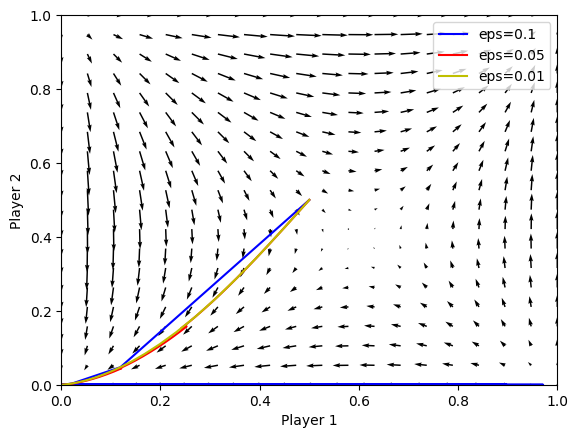

In [51]:
#battle of the sexes
game = battle_of_the_sexes
print(game)
payoff_matrix = game_payoffs_array(game)
dyn = dynamics.MultiPopulationDynamics(payoff_matrix, dynamics.replicator)

#train learners
c_1 = epsilon_greedy(game, 0.1, 100000,0.1)
c_05 = epsilon_greedy(game, 0.05, 100000,0.001)
c_01 = epsilon_greedy(game, 0.01, 100000,0.001)


x_vals = np.linspace(0, 1, 20)
y_vals = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x_vals, y_vals)
# Computing dynamics/vector field
U = np.zeros_like(X)
V = np.zeros_like(Y)
for i in range(len(x_vals)):
    for j in range(len(y_vals)):
        x = np.array([X[i,j],1-X[i,j],Y[i,j],1-Y[i,j]])
        x_dot = dyn(x)
        U[i,j] = x_dot[0]
        V[i,j] = x_dot[2]

# Plot the vector field
fig, ax = plt.subplots()
ax.quiver(X,Y,U,V)
ax.plot(c_1[0],c_1[1],'b',label="eps=0.1")
# ax.plot(c_1[0][0],c_1[1][0],'bo',markersize=20)
# ax.plot(c_1[0][len(c_1[0])-1],c_1[1][len(c_1[1])-1],'bx',markersize=12)
ax.plot(c_05[0],c_05[1],'r',label="eps=0.05")
ax.plot(c_01[0],c_01[1],'y',label="eps=0.01")
ax.set_xlabel("Player 1")
ax.set_ylabel("Player 2")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.legend()
plt.show()

d()


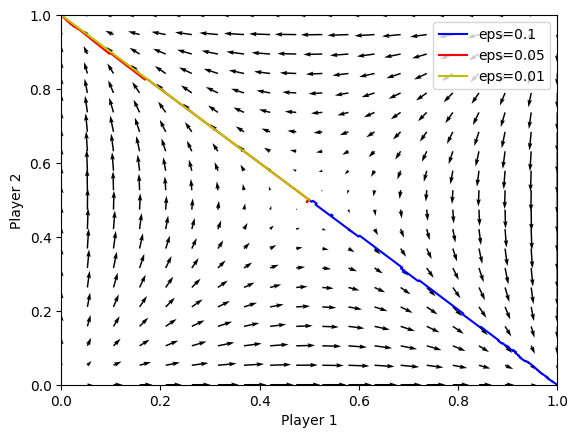

In [33]:
#dispersion
game = dispersion
print(game)
payoff_matrix = game_payoffs_array(game)
dyn = dynamics.MultiPopulationDynamics(payoff_matrix, dynamics.replicator)

#train learners
c_1 = epsilon_greedy(game, 0.1, 100000,0.001)
c_05 = epsilon_greedy(game, 0.05, 100000,0.001)
c_01 = epsilon_greedy(game, 0.01, 100000,0.001)

x_vals = np.linspace(0, 1, 20)
y_vals = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x_vals, y_vals)
# Computing dynamics/vector field
U = np.zeros_like(X)
V = np.zeros_like(Y)
for i in range(len(x_vals)):
    for j in range(len(y_vals)):
        x = np.array([X[i,j],1-X[i,j],Y[i,j],1-Y[i,j]])
        x_dot = dyn(x)
        U[i,j] = x_dot[0]
        V[i,j] = x_dot[2]

# Plot the vector field
fig, ax = plt.subplots()
ax.quiver(X,Y,U,V)
ax.plot(c_1[0],c_1[1],'b',label="eps=0.1")
# ax.plot(c_1[0][0],c_1[1][0],'bo',markersize=20)
# ax.plot(c_1[0][len(c_1[0])-1],c_1[1][len(c_1[1])-1],'bx',markersize=12)
ax.plot(c_05[0],c_05[1],'r',label="eps=0.05")
ax.plot(c_01[0],c_01[1],'y',label="eps=0.01")
ax.set_xlabel("Player 1")
ax.set_ylabel("Player 2")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.legend()
plt.show()

pd()


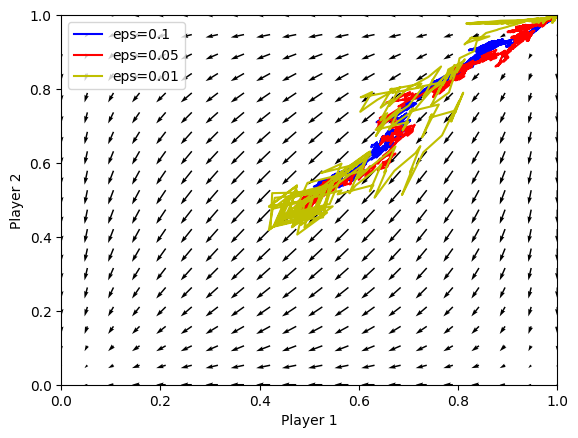

In [35]:
#prisoner dilemma
game = prisoner_dilemma
print(game)
payoff_matrix = game_payoffs_array(game)
dyn = dynamics.MultiPopulationDynamics(payoff_matrix, dynamics.replicator)

#train learners
c_1 = epsilon_greedy(game, 0.1, 100000,0.001)
c_05 = epsilon_greedy(game, 0.05, 100000,0.001)
c_01 = epsilon_greedy(game, 0.01, 100000,0.001)

x_vals = np.linspace(0, 1, 20)
y_vals = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x_vals, y_vals)
# Computing dynamics/vector field
U = np.zeros_like(X)
V = np.zeros_like(Y)
for i in range(len(x_vals)):
    for j in range(len(y_vals)):
        x = np.array([X[i,j],1-X[i,j],Y[i,j],1-Y[i,j]])
        x_dot = dyn(x)
        U[i,j] = x_dot[0]
        V[i,j] = x_dot[2]

# Plot the vector field
fig, ax = plt.subplots()
ax.quiver(X,Y,U,V)
ax.plot(c_1[0],c_1[1],'b',label="eps=0.1")
# ax.plot(c_1[0][0],c_1[1][0],'bo',markersize=20)
# ax.plot(c_1[0][len(c_1[0])-1],c_1[1][len(c_1[1])-1],'bx',markersize=12)
ax.plot(c_05[0],c_05[1],'r',label="eps=0.05")
ax.plot(c_01[0],c_01[1],'y',label="eps=0.01")
ax.set_xlabel("Player 1")
ax.set_ylabel("Player 2")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.legend()
plt.show()

brps()


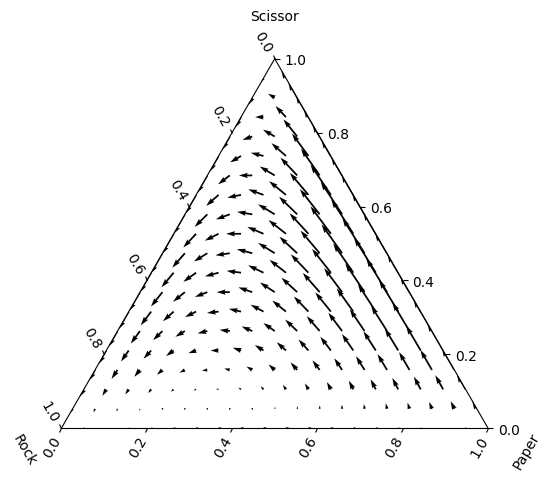

In [45]:
#biased rock paper scissor
# !!!need to install mpltern for plot!!!
game = biased_rock_paper_scissors
print(game)
payoff_matrix = game_payoffs_array(game)
dyn = dynamics.SinglePopulationDynamics(payoff_matrix, dynamics.replicator)

#train learners
c_1 = epsilon_greedy(game, 0.1, 100000,0.001)
c_05 = epsilon_greedy(game, 0.05, 100000,0.001)
c_01 = epsilon_greedy(game, 0.01, 100000,0.001)

X, Y, Z = get_triangular_grid(20)
# Computing dynamics/vector field
U = np.zeros_like(X)
V = np.zeros_like(Y)
W = np.zeros_like(Z)
for i in range(len(U)):
    x = np.array([X[i],Y[i],Z[i]])
    x_dot = dyn(x)
    U[i] = x_dot[0]
    V[i] = x_dot[1]
    W[i] = x_dot[2]
length = np.sqrt(U ** 2 + V ** 2 + W ** 2)
ax = plt.subplot(projection='ternary')
ax.set_tlabel('Scissor')
ax.set_llabel('Rock')
ax.set_rlabel('Paper')
ax.quiver(X,Y,Z,U,V,W)
plt.show()




